# eSMC

In [1]:
# Import packages.
import demes
import demesdraw
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import msprime
import numpy as np
import pandas as pd
import tskit

# Print version numbers.
print("demes", demes.__version__)
print("demesdraw", demesdraw.__version__)
print("matplotlib", matplotlib.__version__)
print("msprime", msprime.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("tskit", tskit.__version__)
# Intialize the matplolib styling.
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
    }
)
# Intialize my pandas preferences.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

demes 0.2.3
demesdraw 0.4.0
matplotlib 3.5.3
msprime 1.2.0
numpy 1.26.0
pandas 1.5.3
tskit 0.5.5


## Simulating Mating System Transitions in `msprime`

* TO-DOs
  * Figure out the piecewise constant mutation rates.

In [2]:
# Initialize a partial selfing class.
class PartialSelfing:
    # Initialize the class.
    def __init__(
        self,
        seq_len: int,
        n_samples: int,
        sample_ploidy: int,
        r: float,
        selfing_config: list[list[float]],
        model: str,
        sim_seed: int,
    ):
        # # Initialize the effective population sizes, effective recombination rates, and event times.
        # N_sigmas = []
        # r_sigmas = []
        # event_times = []
        # # For every event in the selfing configuration.
        # for N_census, sigma, event_time in selfing_config:
        #     # Compute the inbreeding coefficient due to partial selfing.
        #     F = sigma / (2 - sigma)
        #     # Compute the effective population size.
        #     N_sigmas.append(N_census / (1 + F))
        #     # Compute the effective recombination rate.
        #     r_sigmas.append(r * (1 - F))
        #     # Append the event time.
        #     event_times.append(event_time)

        # Initialize a list to store the effective recombination rates, and transition times, demographic objects per selfing transition, the current demographic object for msprime, and the current selfing rate.
        r_sigmas = []
        start_times = []
        end_times = []
        transition_demographies = []
        c_demography = None
        c_sigma = None
        # For every event in the selfing configuration.
        for N_census, sigma, event_time in selfing_config:
            # Compute the inbreeding coefficient due to partial selfing.
            F = sigma / (2 - sigma)
            # Compute the effective population size.
            N_sigma = N_census / (1 + F)
            # If this is the first event.
            if c_demography is None and c_sigma is None:
                # Initialize the current demographic object.
                c_demography = msprime.Demography()
                # Set the initial population size.
                c_demography.add_population(name="PSP", initial_size=N_sigma)
                # Append the transition start time.
                start_times.append(event_time)
                # Append the effective recombination rate.
                r_sigmas.append(r * (1 - F))
            # Else-if there is a change in population size, but no transition in the selfing rate.
            elif c_demography is not None and c_sigma == sigma:
                # Set the population size.
                c_demography.add_population_parameters_change(
                    time=event_time,
                    population="PSP",
                    initial_size=N_sigma,
                )
            # Else there is a transition in the selfing rate.
            else:
                # Append the current demographic object.
                transition_demographies.append(c_demography)
                # Append the transition end and start time.
                end_times.append(event_time)
                start_times.append(event_time)
                # Append the effective recombination rate.
                r_sigmas.append(r * (1 - F))
                # Set the current demographic object.
                c_demography = msprime.Demography()
                # Set the initial population size.
                c_demography.add_population(name="PSP", initial_size=N_sigma)
            # Set the current selfing rate.
            c_sigma = sigma
        # Append the final demographic object and end time.
        transition_demographies.append(c_demography)
        end_times.append(None)
        # Initialize the simulation parameters.
        self.msprime_params = {
            "samples": [msprime.SampleSet(n_samples, ploidy=sample_ploidy)],
            "demography": transition_demographies,
            "sequence_length": seq_len,
            "recombination_rate": r_sigmas,
            "model": model,
            "start_time": start_times,
            "end_time": end_times,
            "random_seed": sim_seed,
        }
        # Initialize a tree sequence.
        ps_ts = None
        # For every selfing rate transition period.
        for i in range(len(transition_demographies)):
            # If this is the first transition period.
            if ps_ts is None:
                # Simulate a tree sequence.
                ps_ts = msprime.sim_ancestry(
                    samples=self.msprime_params["samples"],
                    demography=self.msprime_params["demography"][i],
                    sequence_length=self.msprime_params["sequence_length"],
                    discrete_genome=True,
                    recombination_rate=self.msprime_params["recombination_rate"][i],
                    ploidy=2,
                    model=self.msprime_params["model"],
                    initial_state=None,
                    start_time=None,
                    end_time=self.msprime_params["end_time"][i],
                    record_full_arg=True,
                    random_seed=self.msprime_params["random_seed"],
                )
            # Else there is a transition in the selfing rate.
            else:
                # Simulate a tree sequence.
                ps_ts = msprime.sim_ancestry(
                    demography=self.msprime_params["demography"][i],
                    sequence_length=self.msprime_params["sequence_length"],
                    discrete_genome=True,
                    recombination_rate=self.msprime_params["recombination_rate"][i],
                    ploidy=2,
                    model=self.msprime_params["model"],
                    initial_state=ps_ts,
                    start_time=self.msprime_params["start_time"][i],
                    end_time=self.msprime_params["end_time"][i],
                    record_full_arg=True,
                    random_seed=self.msprime_params["random_seed"],
                )
        self.ts = ps_ts

In [3]:
out2self = PartialSelfing(
    seq_len=1e4,
    n_samples=3,
    sample_ploidy=1,
    r=8.06452e-10,  # Arabidopsis thaliana
    selfing_config=[
        [1e5, 0.5, 0],
        [1e5, 0.0, 2e5],
    ],
    model="smc_prime",
    sim_seed=42,
)

In [4]:
out2self.msprime_params

{'samples': [SampleSet(num_samples=3, population=None, time=None, ploidy=1)],
 'demography': [Demography(populations=[Population(initial_size=75000.0, growth_rate=0, name='PSP', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[], migration_matrix=array([[0.]])),
  Demography(populations=[Population(initial_size=100000.0, growth_rate=0, name='PSP', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[], migration_matrix=array([[0.]]))],
 'sequence_length': 10000.0,
 'recombination_rate': [5.376346666666667e-10, 8.06452e-10],
 'model': 'smc_prime',
 'start_time': [0, 200000.0],
 'end_time': [200000.0, None],
 'random_seed': 42}

In [5]:
self_debugger = out2self.msprime_params["demography"][0].debug()
out_debugger = out2self.msprime_params["demography"][1].debug()

In [6]:
print(self_debugger)
print(out_debugger)

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, inf) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌─────────────────────────────────────────┐
║    │     │     start│       end│growth_rate  │
║    ├─────────────────────────────────────────┤
║    │  PSP│   75000.0│   75000.0│ 0           │
║    └─────────────────────────────────────────┘

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, inf) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌───────────────────────────────────────────┐
║    │     │      start│        end│growth_rate  │
║    ├───────────────────────────────────────────┤
║    │  PSP│   100000.0│   100000.0│ 0           │
║    └───────────────────────────────────────────┘



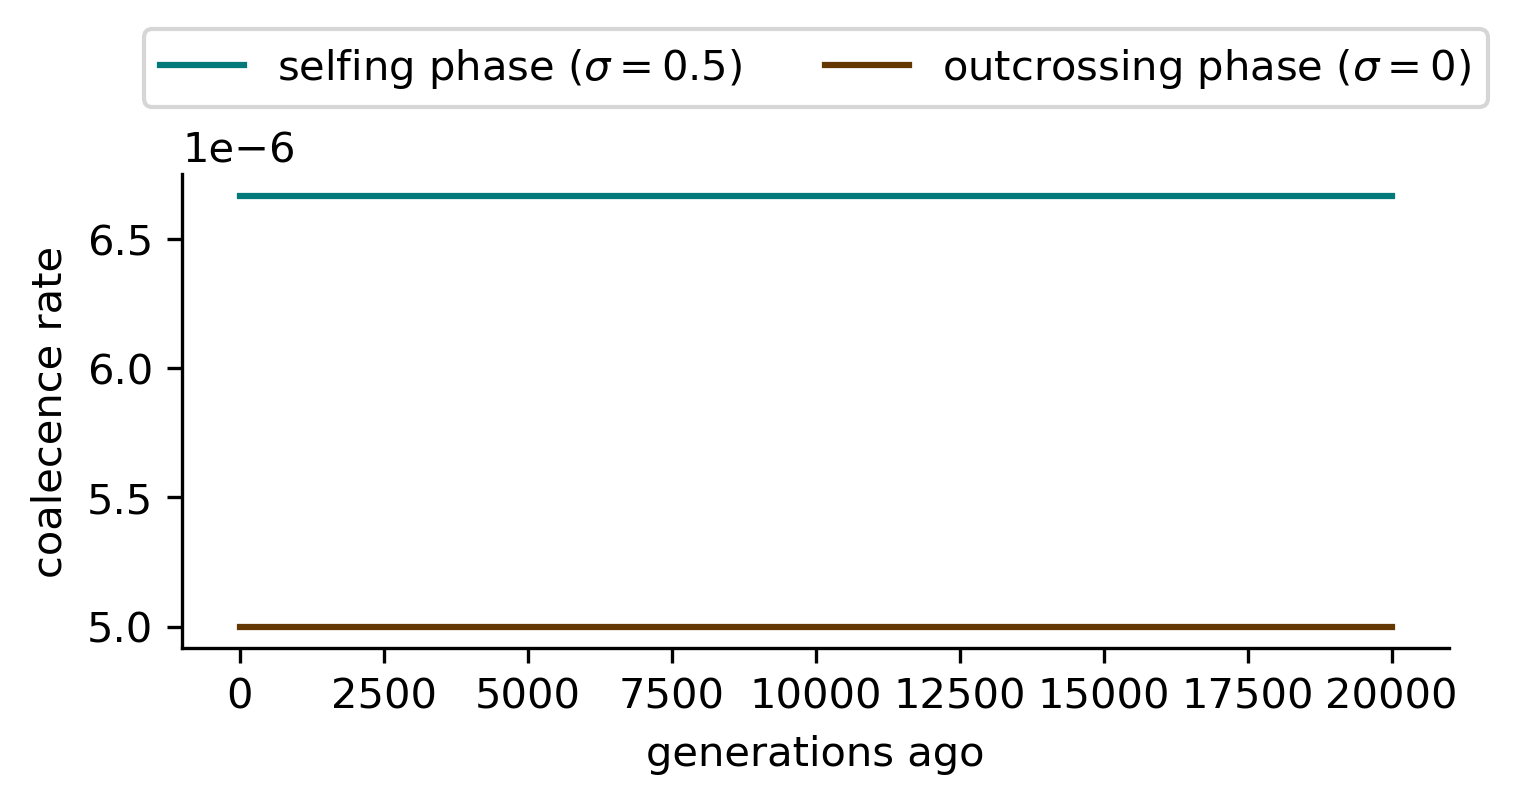

In [7]:
time_steps = np.linspace(0, 2e4, 51)
lambda_self, _ = self_debugger.coalescence_rate_trajectory(time_steps, {"PSP": 2})
lambda_out, _ = out_debugger.coalescence_rate_trajectory(time_steps, {"PSP": 2})
# Intialize the figure.
fig = plt.figure(
    figsize=(5, 2.5),
    dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
ax.plot(time_steps, lambda_self, color="#017a79", label=r"selfing phase ($\sigma=0.5$)")
ax.plot(
    time_steps, lambda_out, color="#653700", label=r"outcrossing phase ($\sigma=0$)"
)
ax.set_xlabel("generations ago")
ax.set_ylabel("coalecence rate")
ax.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.35), frameon=True)
plt.show()

In [8]:
out2self.ts

In [9]:
out2self.ts.tables.nodes[out2self.ts.tables.nodes.flags > 1].time.size

8

In [10]:
np.unique(out2self.ts.tables.nodes[out2self.ts.tables.nodes.flags > 1].time).size

4

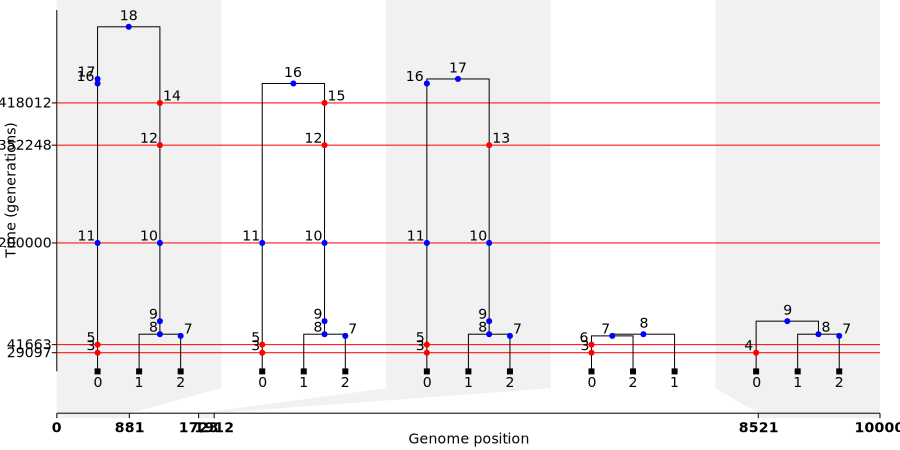

In [12]:
# Plot the recombination nodes in red, with a horizontal line at the time of occurrence,
# and only label nodes that are samples or recombination nodes.
samples = set(out2self.ts.samples())
re_nodes = set(
    nd.id for nd in out2self.ts.nodes() if nd.flags & msprime.NODE_IS_RE_EVENT
)
ca_nodes = set(np.arange(out2self.ts.num_nodes)) - re_nodes - samples
re_times = [
    int(nd.time) for nd in out2self.ts.nodes() if nd.flags & msprime.NODE_IS_RE_EVENT
]
re_times.append(200000)
style = ".y-axis .grid {stroke: #ff000033} .mut .sym {stroke: goldenrod}"
for u in re_nodes:
    style += f".n{u} > .sym {{fill: red}}"
for u in ca_nodes:
    style += f".n{u} > .sym {{fill: blue}}"
style += ".y-axis .tick:nth-child(200000) line {stroke: yellow}"
out2self.ts.draw_svg(
    size=(900, 450),
    y_axis=True,
    y_ticks=re_times,
    y_gridlines=True,
    style=style,
    mutation_labels={},
    node_labels={u: u for u in samples | re_nodes | ca_nodes},
)

In [13]:
out2self.ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,1,0.00000000,
2,1,0,2,0.00000000,
3,131072,0,-1,29097.51691503,
4,131072,0,-1,29097.51691503,
5,131072,0,-1,41663.39343555,
6,131072,0,-1,41663.39343555,
7,0,0,-1,55290.09811004,
8,0,0,-1,57923.41435862,
9,0,0,-1,78224.82353767,
